# ParikhSamuolisReclassificationNN
## date last modified: Nov 11, 2024
### how to link to github --> https://saturncloud.io/blog/how-to-add-jupyter-notebook-to-github/

# Loading Some Necessary Libraries and Setting Paths

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil

In [2]:
## personal directories for entry
## ok basically, because both of our computers won't be set up the exact same way (like for file directories)
## running the command in this cell should get you your file path to paste in the next cell
## all you have to make sure is that you have all the training files and testing files in the ParikhSamuolisReclassificationNN folder
import os
print(os.getcwd())

C:\Users\tomas\OneDrive\Documents\DS340\ParikhSamuolisReclassificationNN


In [3]:
# prompt for the base directory 
base_dir = input("Enter the base directory path for the dataset: ")

# verify the path
print("Base directory set to:", base_dir)

Enter the base directory path for the dataset: C:\Users\tomas\OneDrive\Documents\DS340\ParikhSamuolisReclassificationNN
Base directory set to: C:\Users\tomas\OneDrive\Documents\DS340\ParikhSamuolisReclassificationNN


## Data

In [4]:
# set up data_paths to keep track of each category and split:
# dictionary to store paths for each bird category and split (train/validation)
# set it up on your computer so that in the folder you have 8 folders - 
# baldeagletrain, baldeagleval, blackgrousetrain, blackgrouseval
# chickadeetrain, chickadeeval, goldfinchtrain, goldfinchval

data_paths = {
    'train': {
        'baldeagle': os.path.join(base_dir, 'baldeagletrain'),
        'blackgrouse': os.path.join(base_dir, 'blackgrousetrain'),
        'chickadee': os.path.join(base_dir, 'chickadeetrain'),
        'goldfinch': os.path.join(base_dir, 'goldfinchtrain'),
    },
    'validation': {
        'baldeagle': os.path.join(base_dir, 'baldeagleval'),
        'blackgrouse': os.path.join(base_dir, 'blackgrouseval'),
        'chickadee': os.path.join(base_dir, 'chickadeeval'),
        'goldfinch': os.path.join(base_dir, 'goldfinchval'),
    }
}

# verify each path to make sure everything is correct
for split, categories in data_paths.items():
    for category, path in categories.items():
        print(f"{split} - {category}: {os.path.exists(path)}")

train - baldeagle: True
train - blackgrouse: True
train - chickadee: True
train - goldfinch: True
validation - baldeagle: True
validation - blackgrouse: True
validation - chickadee: True
validation - goldfinch: True


In [5]:
# loading and checking sizes of the images
# found this link for if necessary to resize: https://patrykchrabaszcz.github.io/Imagenet32/
def load_and_check_sizes(data_paths):
    sizes = {}
    for split in ['train', 'validation']:
        sizes[split] = {}
        for category, path in data_paths[split].items():
            sizes[split][category] = []
            for img_name in os.listdir(path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # check for valid image extensions
                    img_path = os.path.join(path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            sizes[split][category].append(img.size)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
    return sizes

image_sizes = load_and_check_sizes(data_paths)
# print(image_sizes)  

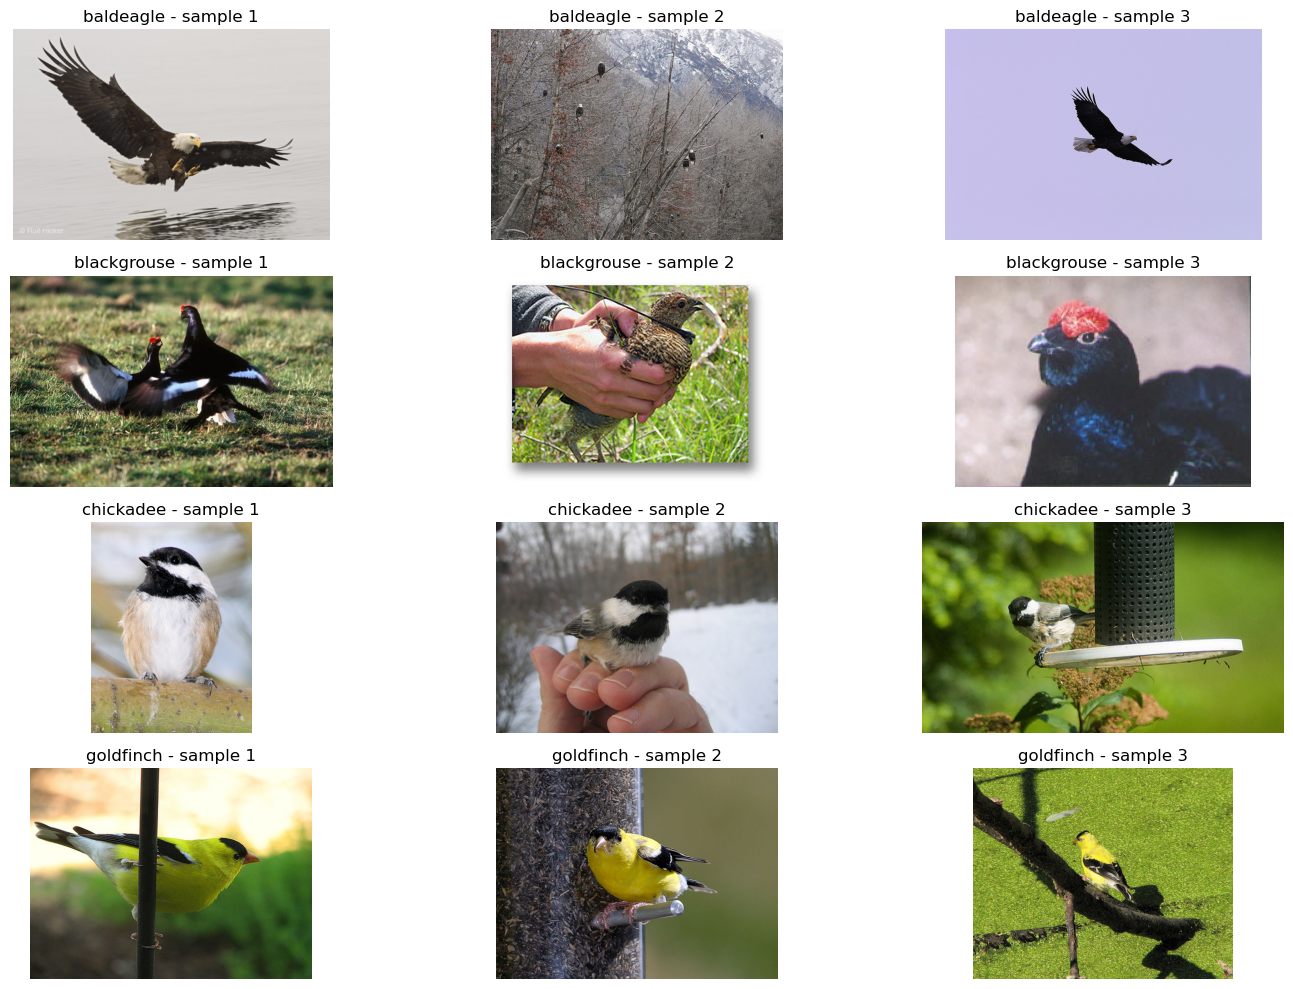

In [6]:
# see if images are displaying properly in each category just as a check
def display_sample_images(data_paths, num_samples=3):
    fig, axs = plt.subplots(4, num_samples, figsize=(15, 10))  # 4 categories, 3 samples each
    
    for i, (category, path) in enumerate(data_paths['train'].items()):
        img_names = os.listdir(path)[:num_samples]
        for j, img_name in enumerate(img_names):
            img_path = os.path.join(path, img_name)
            img = Image.open(img_path)
            axs[i, j].imshow(img)
            axs[i, j].set_title(f"{category} - sample {j+1}")
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images(data_paths)

In [7]:
def resize_images_vgg(data_paths, target_size=(224, 224), save_dir="resized_images"):
    # create the new directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for split in ['train', 'validation']:
        for category, path in data_paths[split].items():
            # create category subfolders in the save directory
            category_dir = os.path.join(save_dir, split, category)
            if not os.path.exists(category_dir):
                os.makedirs(category_dir)

            for img_name in os.listdir(path):
                # skip non-image files like .DS_Store - this lowkey might not be a problem for you tomas, but it was being weird on my mac so i found this fix online
                # having it shouldn't cause you any issues though either because it just won't throw the exception
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):  
                    img_path = os.path.join(path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            img_resized = img.resize(target_size)
                            # Save the resized image to the new directory
                            new_img_path = os.path.join(category_dir, img_name)
                            img_resized.save(new_img_path)  
                    except Exception as e:
                        print(f"Error loading or resizing image {img_path}: {e}")

# resize images and save them in a new folder
resize_images_vgg(data_paths, target_size=(224, 224))

In [8]:
# 11/11 added this so that we also have a binary classification for baldeagle and nonbaldeagle in each folder
# you can run both code blocks it'll be fine
def resize_images_vgg(data_paths, target_size=(224, 224), save_dir="resized_images"):
    # create the new directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for split in ['train', 'validation']:
        # create directories for binary classification: 'baldeagle' and 'nonbaldeagle'
        baldeagle_dir = os.path.join(save_dir, split, 'baldeagle')
        nonbaldeagle_dir = os.path.join(save_dir, split, 'nonbaldeagle')
        
        for category, path in data_paths[split].items():
            # create category subfolders in the save directory
            if not os.path.exists(baldeagle_dir):
                os.makedirs(baldeagle_dir)
            if not os.path.exists(nonbaldeagle_dir):
                os.makedirs(nonbaldeagle_dir)

            for img_name in os.listdir(path):
                # skip non-image files
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):  
                    img_path = os.path.join(path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            img_resized = img.resize(target_size)
                            if category == 'baldeagle':
                                new_img_path = os.path.join(baldeagle_dir, img_name)
                            else:
                                new_img_path = os.path.join(nonbaldeagle_dir, img_name)
                            img_resized.save(new_img_path)  
                    except Exception as e:
                        print(f"Error loading or resizing image {img_path}: {e}")

# resize images and save them in a new folder
resize_images_vgg(data_paths, target_size=(224, 224))

In [13]:
def load_and_prepare_data(data_paths, target_size=(224, 224)):
    data = {'train': {}, 'validation': {}}
    
    for split in ['train', 'validation']:
        for category, path in data_paths[split].items():
            images = []
            labels = []
            label = list(data_paths[split].keys()).index(category)  # numeric label for each category
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                # skip non-image files (mac only issue?)
                if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                with Image.open(img_path) as img:
                    img_resized = img.resize(target_size)
                    img_array = np.array(img_resized) / 255.0  # normalize pixel values
                    if img_array.ndim == 2:  # if the image is grayscale, add a third channel
                        img_array = np.expand_dims(img_array, axis=-1)
                        img_array = np.repeat(img_array, 3, axis=-1)  # repeat the grayscale to rgb
                    images.append(img_array)
                    labels.append(label)
            # store images and labels for each category as 3D arrays
            data[split][category] = (np.array(images), np.array(labels))
    
    return data

# prepare the data
prepared_data = load_and_prepare_data(data_paths, target_size=(224, 224))

# verifying shape of loaded data arrays
for split in prepared_data:
    for category in prepared_data[split]:
        images, labels = prepared_data[split][category]
        print(f"{split} - {category}: images shape = {images.shape}, labels shape = {labels.shape}")

train - baldeagle: images shape = (1300, 224, 224, 3), labels shape = (1300,)
train - blackgrouse: images shape = (1300, 224, 224, 3), labels shape = (1300,)
train - chickadee: images shape = (1300, 224, 224, 3), labels shape = (1300,)
train - goldfinch: images shape = (1300, 224, 224, 3), labels shape = (1300,)
validation - baldeagle: images shape = (50, 224, 224, 3), labels shape = (50,)
validation - blackgrouse: images shape = (50, 224, 224, 3), labels shape = (50,)
validation - chickadee: images shape = (50, 224, 224, 3), labels shape = (50,)
validation - goldfinch: images shape = (50, 224, 224, 3), labels shape = (50,)


In [14]:
prepared_data

{'train': {'baldeagle': (array([[[[0.85490196, 0.85098039, 0.84313725],
            [0.85490196, 0.85098039, 0.84313725],
            [0.85490196, 0.85098039, 0.84313725],
            ...,
            [0.85882353, 0.84313725, 0.83137255],
            [0.85882353, 0.84313725, 0.83137255],
            [0.85882353, 0.84313725, 0.83137255]],
   
           [[0.85490196, 0.85098039, 0.84313725],
            [0.85490196, 0.85098039, 0.84313725],
            [0.85490196, 0.85098039, 0.84313725],
            ...,
            [0.85882353, 0.84313725, 0.83137255],
            [0.8627451 , 0.84705882, 0.83529412],
            [0.8627451 , 0.84705882, 0.83529412]],
   
           [[0.85490196, 0.85098039, 0.84313725],
            [0.85490196, 0.85098039, 0.84313725],
            [0.85490196, 0.85098039, 0.84313725],
            ...,
            [0.8627451 , 0.84705882, 0.83529412],
            [0.8627451 , 0.84705882, 0.83529412],
            [0.8627451 , 0.84705882, 0.83529412]],
   
           .

In [9]:
# 11/11 added this bc of the other add lol
import random

def load_and_prepare_data(data_paths,frac_misclass, target_size=(224, 224), ):
    random.seed(150)

    data = {'train': {'baldeagle': [], 'nonbaldeagle': []}, 'validation': {'baldeagle': [], 'nonbaldeagle': []}}
    
    for split in ['train', 'validation']:
        for category, path in data_paths[split].items():
            label = 1 if category == 'baldeagle' else 0  # 1 for 'baldeagle', 0 for 'nonbaldeagle'
            
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                # skip non-image files
                if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                with Image.open(img_path) as img:
                    img_resized = img.resize(target_size)
                    img_array = np.array(img_resized) / 255.0  # normalize pixel values
                    if img_array.ndim == 2:  # if the image is grayscale, add a third channel
                        img_array = np.expand_dims(img_array, axis=-1)
                        img_array = np.repeat(img_array, 3, axis=-1)  # repeat the grayscale to rgb
                    data[split]['baldeagle' if label == 1 else 'nonbaldeagle'].append((img_array, label))
    
    for split in ['train', 'validation']:
        random_n = random.sample(data[split]['baldeagle'], k = frac_misclass*len(data[split]['baldeagle']))
        random_n = np.array(random_n)
        indices = []
        for image in random_n:
            indices.append(np.where(random_n == image)[0][0])
        np.delete(data[split]['baldeagle'], [indices])
        np.append(data[split]['nonbaldeagle'], random_n)
            
    
    
    for split in ['train', 'validation']:
        for label in ['baldeagle', 'nonbaldeagle']:
            data[split][label] = np.array([item[0] for item in data[split][label]]), np.array([item[1] for item in data[split][label]])

   
            
            
    return data

# prepare the data
prepared_data = load_and_prepare_data(data_paths, target_size=(224, 224), frac_misclass = 0)

# verifying shape of loaded data arrays
for split in prepared_data:
    for label in prepared_data[split]:
        images, labels = prepared_data[split][label]
        print(f"{split} - {label}: images shape = {images.shape}, labels shape = {labels.shape}")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1300, 2) + inhomogeneous part.

{'baldeagle': (array([[[[0.85490196, 0.85098039, 0.84313725],
           [0.85490196, 0.85098039, 0.84313725],
           [0.85490196, 0.85098039, 0.84313725],
           ...,
           [0.85882353, 0.84313725, 0.83137255],
           [0.85882353, 0.84313725, 0.83137255],
           [0.85882353, 0.84313725, 0.83137255]],
  
          [[0.85490196, 0.85098039, 0.84313725],
           [0.85490196, 0.85098039, 0.84313725],
           [0.85490196, 0.85098039, 0.84313725],
           ...,
           [0.85882353, 0.84313725, 0.83137255],
           [0.8627451 , 0.84705882, 0.83529412],
           [0.8627451 , 0.84705882, 0.83529412]],
  
          [[0.85490196, 0.85098039, 0.84313725],
           [0.85490196, 0.85098039, 0.84313725],
           [0.85490196, 0.85098039, 0.84313725],
           ...,
           [0.8627451 , 0.84705882, 0.83529412],
           [0.8627451 , 0.84705882, 0.83529412],
           [0.8627451 , 0.84705882, 0.83529412]],
  
          ...,
  
          [[0.81176471, 0.7

## Checking initial accuracy of vgg - NOT FINISHED/DONE
### Use resized images folder (not misclassified)

START NEW WORK HERE 
TO DO:
create baseline nn accuracy score using vgg 16
eagle non eagle accuracy has to be found 
use resized images folder

i have no idea if the below code works beause i did not want to open up my scc atm

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# define directories for train and validation sets
root_dir = '/projectnb/ds340/projects/Samuolis_Parikh_Image_Data/'

train_dir = root_dir +"resized_images/train/"
validation_dir = root_dir + "resized_images/validation"

# set up the ImageDataGenerator without augmentation for baseline accuracy
data_gen_args = {
    'rescale': 1.0 / 255.0,  # Normalize pixel values
}

train_datagen = ImageDataGenerator(**data_gen_args)
validation_datagen = ImageDataGenerator(**data_gen_args)

# load data with binary labels
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # binary mode for baldeagle (1) vs nonbaldeagle (0)
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
)

# load the VGG16 model with pre-trained ImageNet weights, excluding the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# freeze the base model layers to retain ImageNet-trained weights
for layer in base_model.layers:
    layer.trainable = False

# add new fully connected layers for binary classification
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # sigmoid for binary 

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train model
history = model.fit(
    train_generator,
    epochs=20,  # You can adjust this for more epochs as needed
    validation_data=validation_generator
)

# evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


Found 5200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8176 - loss: 0.8074 - val_accuracy: 0.9100 - val_loss: 0.1808
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9651 - loss: 0.0996 - val_accuracy: 0.9200 - val_loss: 0.1829
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9862 - loss: 0.0505 - val_accuracy: 0.9200 - val_loss: 0.1663
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9889 - loss: 0.0330 - val_accuracy: 0.9100 - val_loss: 0.1713
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9895 - loss: 0.0318 - val_accuracy: 0.9150 - val_loss: 0.2207
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9973 - loss: 0.0117 - val_accuracy: 0.9300 - val_loss: 0.1563
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.9400 - val_loss: 0.1591
Epoch 8/20
16

## Starting Relabeling of Baldeagle to Blackgrouse

### Only picking one other category to reclassify to  simplify the setup and analysis, as we’d only need to track whether the model can reclassify them from one incorrect category

In [ ]:
import os
import shutil
import random

def create_misclassified_folder(original_folder, new_folder_name="misclassified20"):
    if not os.path.exists(new_folder_name):
        shutil.copytree(original_folder, new_folder_name)
    return new_folder_name

def relabel_images_with_non_bald_eagle(category_to_mislabel, target_category, data_paths, percentage=0.2, new_folder_name="misclassified20"):
    # altered from 11/8 so that we dont keep overwriting files
    # each time we do a misclassifcation we have to make a new directory (ex: resized_images20 for 20% misclassified)
    new_resized_images_folder = create_misclassified_folder("resized_images", new_folder_name)

    # defining paths in the new misclassified folder
    original_folder = os.path.join(new_resized_images_folder, 'train', category_to_mislabel)
    target_folder = os.path.join(new_resized_images_folder, 'train', target_category)
    non_bald_eagle_folder = os.path.join(new_resized_images_folder, 'train', 'nonbaldeagle')
    
    # create the nonbaldeagle folder if it doesn't exist
    if not os.path.exists(non_bald_eagle_folder):
        os.makedirs(non_bald_eagle_folder)

    images = [img for img in os.listdir(original_folder) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # number of images to move based on the specified percentage
    num_to_move = int(len(images) * percentage)
    images_to_relabel = random.sample(images, num_to_move)

    # moving selected images to the target category folder and copy to nonbaldeagle folder
    for img_name in images_to_relabel:
        img_path = os.path.join(original_folder, img_name)
        new_path = os.path.join(target_folder, img_name)
        non_bald_eagle_path = os.path.join(non_bald_eagle_folder, img_name)

        # moving the image to the target category
        shutil.move(img_path, new_path)
        # copying the image to the nonbaldeagle folder
        shutil.copy(new_path, non_bald_eagle_path)

        print(f"Moved {img_name} from {category_to_mislabel} to {target_category} and copied to nonbaldeagle")

relabel_images_with_non_bald_eagle('baldeagle', 'blackgrouse', data_paths, percentage=0.2, new_folder_name="misclassified20")


In [12]:
# want to know how many images are in each category after "misclassifying"
def count_images_in_categories(base_folder):
    for split in ['train', 'validation']:
        print(f"\nCategory counts in '{split}' folder:")
        split_path = os.path.join(base_folder, split)
        
        for category in os.listdir(split_path):
            category_path = os.path.join(split_path, category)
            if os.path.isdir(category_path):  # Check if it's a directory
                num_images = len([img for img in os.listdir(category_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
                print(f"  {category}: {num_images} images")

count_images_in_categories("misclassified20")


Category counts in 'train' folder:
  nonbaldeagle: 4160 images
  chickadee: 1300 images
  baldeagle: 1040 images
  blackgrouse: 1560 images
  goldfinch: 1300 images

Category counts in 'validation' folder:
  nonbaldeagle: 150 images
  chickadee: 50 images
  baldeagle: 50 images
  blackgrouse: 50 images
  goldfinch: 50 images
